In [1]:
# -- Use the following for Google Colab
#! pip install -q 'lalsuite==6.66' 'PyCBC==1.15.3' 

## Dowloading GW events

Below we will use the Pycbc functions to download data correspondant to GW150914. PyCBC is build on two types of classes: timeseries and frequencyseries classes. These classes contains several methods that are useful for GW data analysis

In [1]:
%matplotlib inline

# Read in the data around GW150914
from pycbc.catalog import Merger
import matplotlib.pyplot as plt

m = Merger('GW150914')

data = {}
for ifo in ['H1', 'L1']:
    data[ifo] = m.strain(ifo)

/anaconda3/envs/igwn-py37/lib/python3.7/site-packages/IPython/core/pylabtools.py:131: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


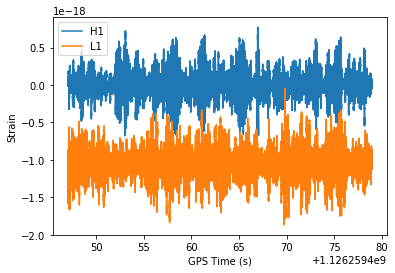

In [2]:
for ifo in data:
    plt.plot(data[ifo].sample_times, data[ifo], label=ifo)

plt.ylabel('Strain')
plt.xlabel('GPS Time (s)')
plt.legend()
plt.show()

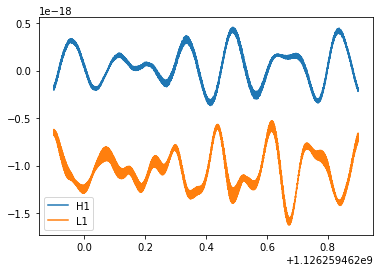

In [3]:
for ifo in data:
    # Here we are cutting  just visualizing the data withing 1 second from the merger time
    zoom = data[ifo].time_slice(m.time - 0.5, m.time + 0.5)
    plt.plot(zoom.sample_times, zoom, label=ifo)

plt.legend()
plt.show()

As you can see, the data does not look like the cool plots that we show around. Before obtaining those plots, we need to further clean the data. GW data is strongly contaminated by low-frequency seismic noise. So we need to cut off all the frequency components which are below 15 Hz. We need to pass an high pass filter.

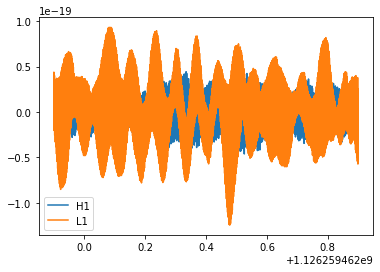

In [5]:
for ifo in data:
    high_data = data[ifo].highpass_fir(15, 512) # Highpass point is 15 Hz
    zoom = high_data.time_slice(m.time - 0.5, m.time + 0.5)
    plt.plot(zoom.sample_times, zoom, label=ifo)

plt.legend()
plt.show()

The situation now it's better, as you can see, we have removed from L1 the continuous background. Now the time series is still centered around 0.
However, if you remember from the lecture, the noise in LIGO and Virgo does not have the same frequency components. The noise in some frequency bands is stronger than in the others. So what we are observing is not white gaussian noise, but instead coulered noise plus some noise lines. We need to estimate the power spectral density and renormalize our data

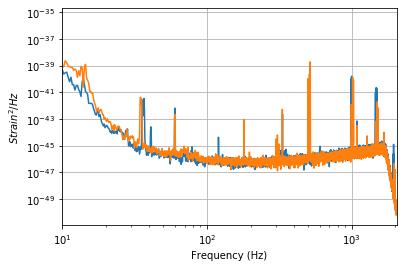

In [8]:
for ifo in data:
    # This estimates the PSD by sub-dividing the data into overlapping
    # 4s long segments
    psd = data[ifo].psd(4)
    
    # Note that the psd is a FrequencySeries!
    plt.loglog(psd.sample_frequencies, psd)
    
plt.ylabel('$Strain^2 / Hz$')
plt.xlabel('Frequency (Hz)')
plt.grid()
plt.xlim(10, 2048)
plt.show()

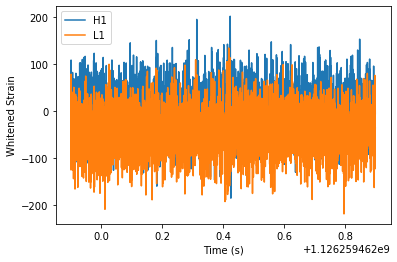

In [10]:
# Whiten the data
whitened = {}

for ifo in data:
    whitened[ifo] = data[ifo].whiten(4, 4)

    zoom = whitened[ifo].time_slice(m.time - 0.5, m.time + 0.5)
    plt.plot(zoom.sample_times, zoom, label=ifo)

plt.ylabel('Whitened Strain')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

The data is now "whitened", i.e. the noise is white and gaussian (with a flat spectrum). If there is a strong singal, now we might be able to see it. We want to zoom now!

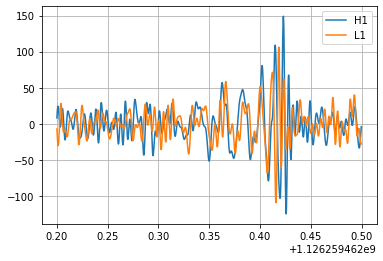

In [16]:
for ifo in whitened:
    # Apply a highpass filter (at 30 Hz) followed by an lowpass filter (at 250 Hz)
    bpsd = whitened[ifo].highpass_fir(30, 512).lowpass_fir(250, 512)
    
    zoom = bpsd.time_slice(m.time - 0.2, m.time + 0.1)
    plt.plot(zoom.sample_times, zoom, label=ifo)

plt.grid()
plt.legend()
plt.show()


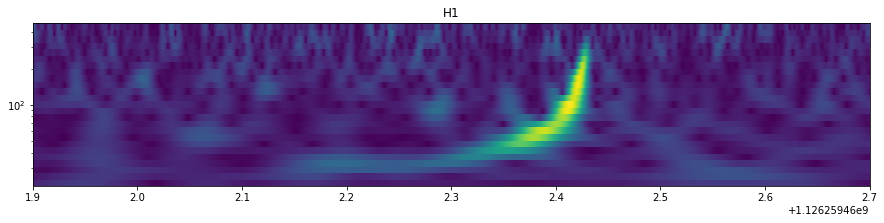

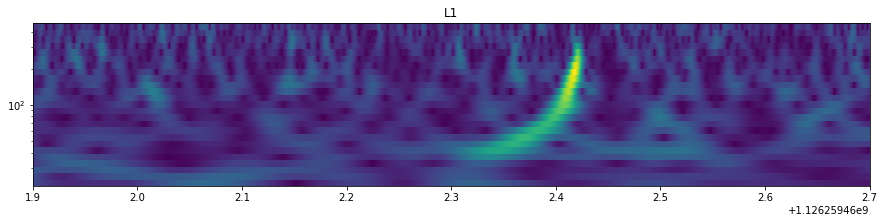

In [20]:
for ifo in whitened:
    # We'll choose a tighter zoom here.
    zoom = whitened[ifo].time_slice(m.time - 5, m.time + 5)
    times, freqs, power = zoom.qtransform(qrange=(8, 8),
                                                frange=(20, 512))
    plt.figure(figsize=[15, 3])
    plt.pcolormesh(times, freqs, power**0.5)
    plt.xlim(m.time - 0.5, m.time + 0.3)
    plt.title(ifo)
    plt.yscale('log')
    plt.show()

## Challenge GW170817

In [23]:
%matplotlib inline

# Read in the data around GW150914
from pycbc.catalog import Merger
import pylab

m = Merger('GW170814')

data = {}
for ifo in ['H1', 'L1','V1']:
    data[ifo] = m.strain(ifo)

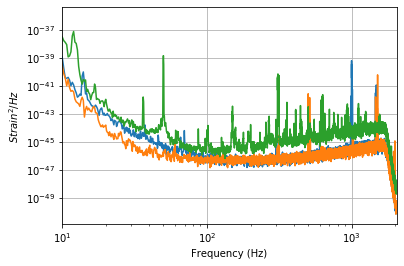

In [24]:
for ifo in data:
    # This estimates the PSD by sub-dividing the data into overlapping
    # 4s long segments. (See Welch's method)
    psd = data[ifo].psd(4)
    
    # Note that the psd is a FrequencySeries!
    pylab.loglog(psd.sample_frequencies, psd)
    
pylab.ylabel('$Strain^2 / Hz$')
pylab.xlabel('Frequency (Hz)')
pylab.grid()
pylab.xlim(10, 2048)
pylab.show()

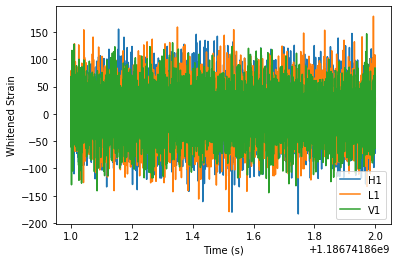

In [25]:
# Whiten the data
whitened = {}

for ifo in data:
    # This produces a whitened set.
    # This works by estimating the power spectral density from the
    # data and then flattening the frequency response.
    # (1) The first option sets the duration in seconds of each
    #     sample of the data used as part of the PSD estimate.
    # (2) The second option sets the duration of the filter to apply
    whitened[ifo] = data[ifo].whiten(4, 4)

    zoom = whitened[ifo].time_slice(m.time - 0.5, m.time + 0.5)
    pylab.plot(zoom.sample_times, zoom, label=ifo)

pylab.ylabel('Whitened Strain')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.show()

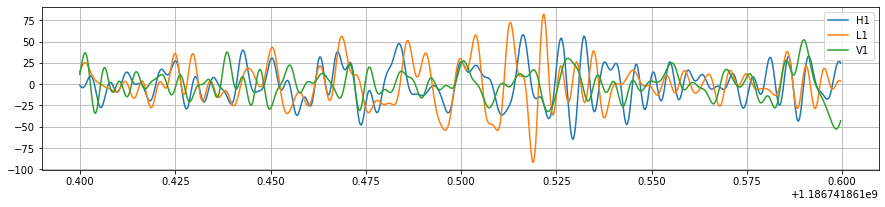

In [26]:
pylab.figure(figsize=[15, 3])
for ifo in whitened:
    # Apply a highpass filter (at 30 Hz) followed by an lowpass filter (at 250 Hz)
    bpsd = whitened[ifo].highpass_fir(30, 512).lowpass_fir(250, 512)
    
    # We'll choose a tighter zoom here.
    zoom = bpsd.time_slice(m.time - .1, m.time + .1)
    pylab.plot(zoom.sample_times, zoom, label=ifo)

pylab.grid()
pylab.legend()
pylab.show()

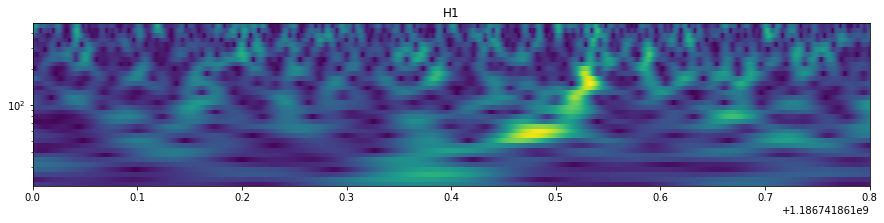

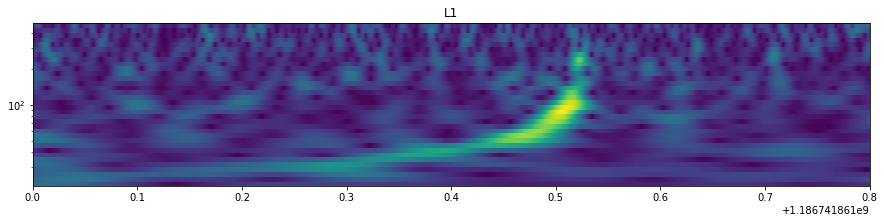

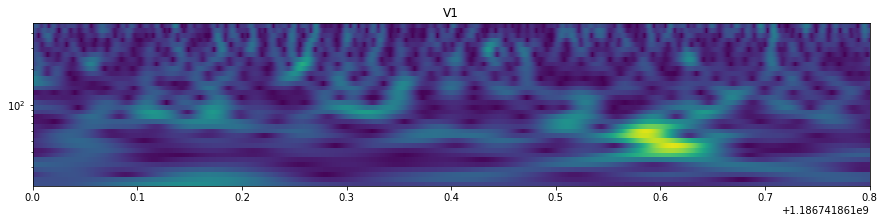

In [27]:
for ifo in whitened:
    # We'll choose a tighter zoom here.
    zoom = whitened[ifo].time_slice(m.time - 5, m.time + 5)
                    
    # The qtransform method returns a vector of the sample times, frequencies, and a 2-d vector of the 
    # power in each time-frequency bin. The free parameter is the choice of the Q-value. Larger Q-values
    # are generally more appropriate for viewing long duration features of the data and vice versa. 
                    
    # The options here:
    # (1) The time spacing for the output image (i.e. 1 ms in this case)
    # (2) The number of frequency bins in the output, logarithmically spaced
    # (3) The qrange to maximize over. We'll pick a constant at 8 here
    #     Typically higher values will be more appropriate for longer duration
    #     signals
    # (4) The frequency range to output
    times, freqs, power = zoom.qtransform(qrange=(10, 12),frange=(20, 512))
    pylab.figure(figsize=[15, 3])
    pylab.pcolormesh(times, freqs, power**0.5)
    pylab.xlim(m.time - 0.5, m.time + 0.3)
    pylab.title(ifo)
    pylab.yscale('log')
    pylab.show()